In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
plt.rc('font', family = 'Malgun Gothic')
import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans,DBSCAN
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

In [3]:
df = pd.read_excel('../data/20230818/수입검사결과.xlsx',engine='openpyxl')

C:\python\ml308\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [7]:
df.head(3)

,수입신고번호,란번호,신고세관부호,신고과코드,검사일자,수입검사결과코드,신고품명,거래품명,조치내용
0,1393518400666M,4,20,12,20180201,C1,DECORATION CRAFTS,DECORATION CRAFTS,"수량, 중량부족(과세가격 감소)"
1,4352118000216M,2,20,12,20180202,N3,PARTS OF WORKING TOOLS,POST DRIVER PARTS,원산지·적출국 오류정정
2,1235618113568M,1,40,58,20180202,N5,WHEEL,WHEEL,기타 신고항목 오류정정


In [8]:
len(df)

790651

In [9]:
ddf = df[df['수입검사결과코드'].isin (['T6','D6','E4'])].copy()

In [10]:
ddf.head(3)

,수입신고번호,란번호,신고세관부호,신고과코드,검사일자,수입검사결과코드,신고품명,거래품명,조치내용
45,1364018233720M,1,40,58,20180514,E4,NATURAL HONEY,MANUKA HONEY 1KG,기타 국민보건 등 침해물품 수입(통관보류)
221,4315018900510M,1,30,81,20180411,D6,PARTS OF MECHANICAL APPLIANCES FOR PROJECTING,"SPRINKLER HEAD WITH COVER,VIKING",기타 원산지 관련사항 위반
365,1334118C62295M,1,40,94,20190110,E4,OTHER,CENTRUM SILVER,기타 국민보건 등 침해물품 수입(통관보류)


In [11]:
len(ddf)

19561

In [12]:
ddf['조치내용'] = ddf['조치내용'].fillna('')

In [13]:
ddf['total_text'] = ddf['조치내용']

In [14]:
ddf['total_text'] = ddf['total_text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z ]","", regex=True)
ddf['total_text'] = ddf['total_text'].str.replace("ㅇ","", regex=True)

In [15]:
# 결측행 삭제
ddf['total_text'].dropna(axis=0)

45            기타 국민보건 등 침해물품 수입통관보류
221                  기타 원산지 관련사항 위반
365           기타 국민보건 등 침해물품 수입통관보류
519              동일세번내 고세율로 변경FTA관련
539           기타 국민보건 등 침해물품 수입통관보류
                    ...            
790407    기타 국민건강사회안전 등 침해물품 수입통관보류
790410    기타 국민건강사회안전 등 침해물품 수입통관보류
790412    기타 국민건강사회안전 등 침해물품 수입통관보류
790512               기타 원산지 관련사항 위반
790639          란 행 BOVINE COLLAGEN
Name: total_text, Length: 19561, dtype: object

In [16]:
len(df),len(ddf)

(790651, 19561)

In [17]:
def wordcloud(grp, model):
    g1 = ddf[ddf[model] == grp].groupby('total_text')['total_text'].count().reset_index(name='cnt')
    
    # 결과를 딕셔너리로 변환
    g1_ditc = {}
    for idx, row in enumerate(g1.iterrows()):
        g1_ditc[row[1]['total_text']] = row[1]['cnt']

    wordcloud = WordCloud(
        font_path='malgun.ttf', # 한글 글씨체 설정
        background_color='white', # 배경색은 흰색으로 
        colormap='Reds', # 글씨색은 빨간색으로
        mask=None, # 워드클라우드 모양 설정
        width=800, height=800 # 이미지 크기 설정
    ).generate_from_frequencies(g1_ditc)
    
    # 사이즈 설정 및 출력
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') # 차트로 나오지 않게
    plt.title(str(grp) +'번 그룹 WordCloud')
    plt.savefig(str(model)+ '_' + str(grp) +'.png', facecolor='#eeeeee')
    plt.show()

    print('---' * 30)

In [ ]:
okt = Okt() # 형태소 분석기 객체 생성
noun_list = []
for content in tqdm.tqdm(ddf['total_text'].fillna('')): 
    nouns = okt.nouns(content) # 명사만 추출하기, 결과값은 명사 리스트
    noun_list.append(nouns)

In [15]:
ddf['nouns'] = noun_list

In [16]:
ddf.head(3)

,수입신고번호,란번호,신고세관부호,신고과코드,검사일자,수입검사결과코드,신고품명,거래품명,조치내용,total_text,nouns
45,1364018233720M,1,40,58,20180514,E4,NATURAL HONEY,MANUKA HONEY 1KG,기타 국민보건 등 침해물품 수입(통관보류),기타 국민보건 등 침해물품 수입통관보류,"[기타, 국민, 보건, 등, 침해, 물품, 수입, 통관, 보류]"
221,4315018900510M,1,30,81,20180411,D6,PARTS OF MECHANICAL APPLIANCES FOR PROJECTING,"SPRINKLER HEAD WITH COVER,VIKING",기타 원산지 관련사항 위반,기타 원산지 관련사항 위반,"[기타, 원산지, 관련, 사항, 위반]"
365,1334118C62295M,1,40,94,20190110,E4,OTHER,CENTRUM SILVER,기타 국민보건 등 침해물품 수입(통관보류),기타 국민보건 등 침해물품 수입통관보류,"[기타, 국민, 보건, 등, 침해, 물품, 수입, 통관, 보류]"


In [17]:
# 명사 리스트가 비어있으면 DataFrame에서 지
drop_index_list = [] # 지워버릴 index를 담는 리스트
for i, row in ddf.iterrows():
    temp_nouns = row['nouns']
    if len(temp_nouns) == 0: # 만약 명사리스트가 비어 있다면
        drop_index_list.append(i) # 지울 index 추가
        
ddf = ddf.drop(drop_index_list) # 해당 index를 지우기

# index를 지우면 순회시 index 값이 중간중간 비기 때문에 index를 다시 지정
ddf.index = range(len(ddf))

In [18]:
# 단어를 문장으로 합침
[" ".join(noun) for noun in ddf['nouns'][10:12]]

['세번 국세 부과', '기타 원산지 관련 사항 위반']

In [19]:

# 문서를 명사 집합으로 보고 문서 리스트로 치환 (tfidfVectorizer 인풋 형태를 맞추기 위해)
text = [" ".join(noun) for noun in ddf['nouns']]

# min-df 특정단어가 문서에 나타는 빈도수 (예 : 4개 문장에 home이 4번 등장하나 단어를 포함하는 문장이 3개이면 df=3임)
# ngram_range : 1로 설정하면 단어별 벡터를 만들고 5로 설정하면 한 단어부터 5개 단어까지 묶어서 개별 벡터 생성
tfidf_vectorizer = TfidfVectorizer(min_df=2,ngram_range=(1,10))
# 문장을 하나로 벡터화 학습
tfidf_vectorizer.fit(text)

# tfidf_vectorizer.vocabulary_ # 벡터라이저가 학습한 단어사전 출력
# 행별 학습한 벡터를 배열로 반환
vector = tfidf_vectorizer.transform(text).toarray()

In [20]:
# 행의 수, 벡터차원
vector.shape

(19552, 4956)

In [21]:
vector[:][1]

array([0., 0., 0., ..., 0., 0., 0.])

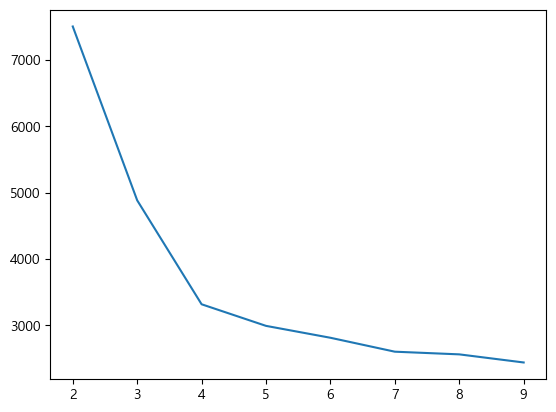

In [22]:
# 그룹수 튜닝
itr = []
for i in range(2,10):
    km = KMeans(n_clusters=i, n_init=5,random_state=42)
    km.fit(vector)
    itr.append(km.inertia_)
    
plt.plot(range(2,10), itr)
plt.show() 

In [23]:
# Kmeans : 클러스터 중심점과 가까운 데이터를 클러스터

# 첫번째 꺽임점 4를 우선 고려 다음 꺽임점 6를 두번째로 고려

model = KMeans(n_clusters=4, random_state=42, init='k-means++',max_iter=100, n_init=1)
model.fit(vector)

KMeans(max_iter=100, n_clusters=4, n_init=1, random_state=42)

In [24]:
# 그룹핑 결과를 데이터프레임에 적용
ddf['kmeans'] = model.labels_

In [25]:
ddf['kmeans'].value_counts()

0    8993
2    4569
1    3639
3    2351
Name: kmeans, dtype: int64

In [26]:
np.unique(model.labels_)

array([0, 1, 2, 3])

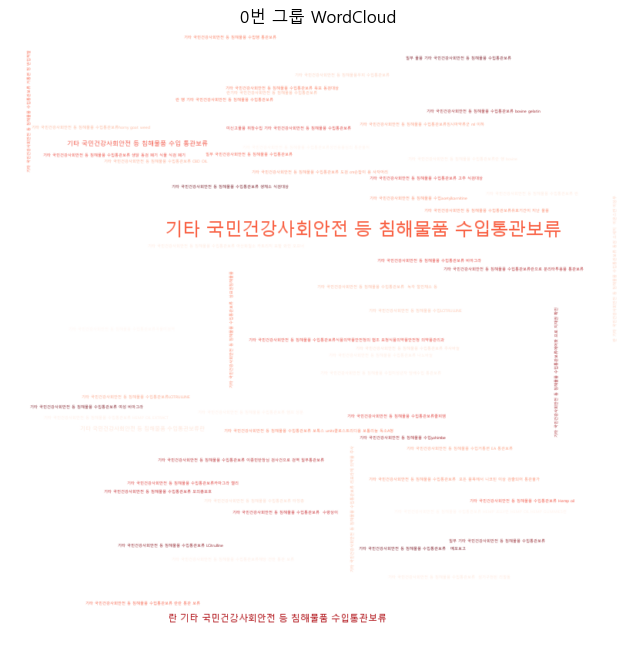

------------------------------------------------------------------------------------------


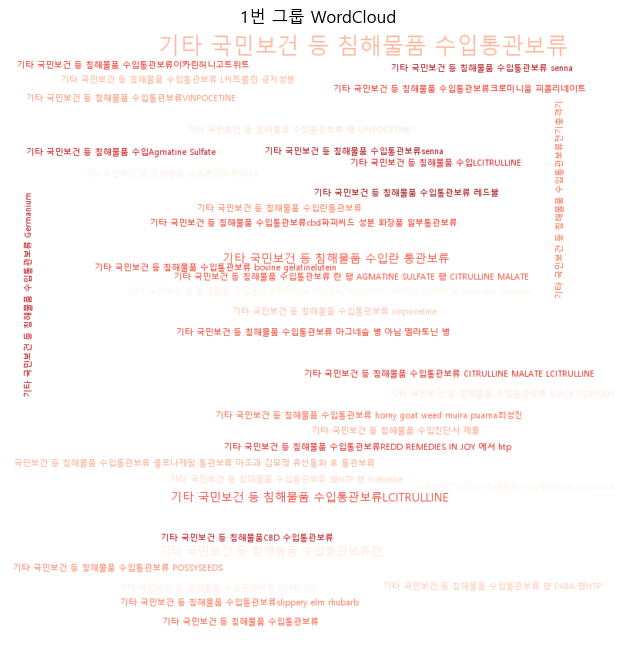

------------------------------------------------------------------------------------------


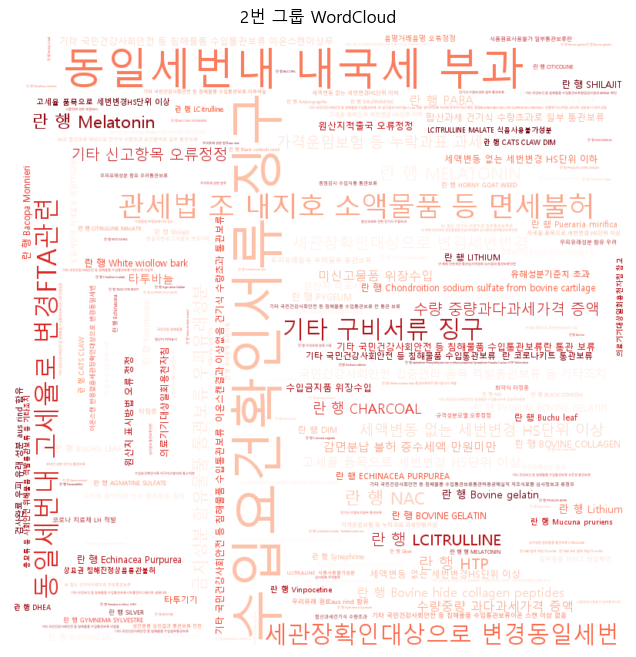

------------------------------------------------------------------------------------------


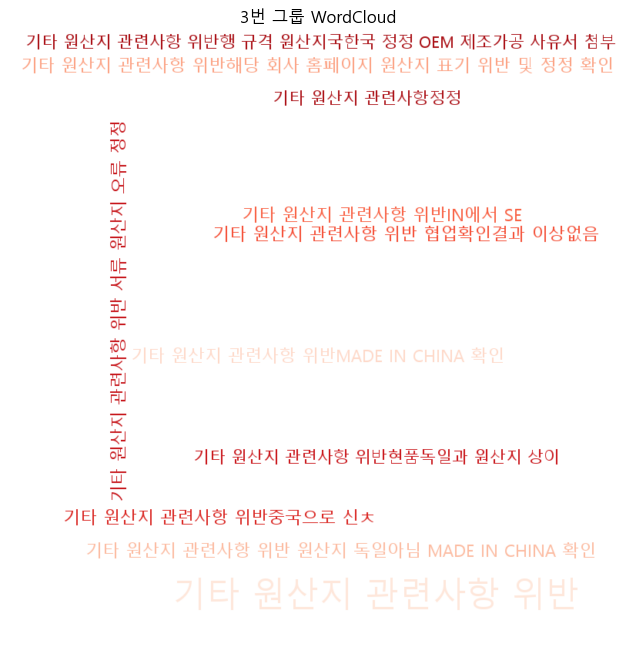

------------------------------------------------------------------------------------------


In [27]:
# 그룹별 워드클라우드 시각화
for i in range(ddf['kmeans'].max()+1):
    wordcloud(i,'kmeans')

In [1]:
# DBSCAN : 인접한 데이터를 클러스터링

vector = np.array(vector) # Normalizer를 이용해 변환된 벡터
# eps 그룹핑할 최대 반경거리
# min_samples 그룹핑한 반경안의 최소 샘플 갯수
model = DBSCAN(eps=1.0,min_samples=130)

# 거리 계산 식으로는 Cosine distance를 이용
model.fit(vector)
result = model.fit_predict(vector)

NameError: name 'np' is not defined

In [29]:
ddf['dbscan'] = result

In [30]:
np.unique(ddf['dbscan'])

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int64)

In [31]:
ddf['dbscan'].value_counts()

 4    8989
 0    3639
 1    2349
-1    2149
 7    1187
 6     355
 3     222
 2     191
 9     190
 8     147
 5     134
Name: dbscan, dtype: int64

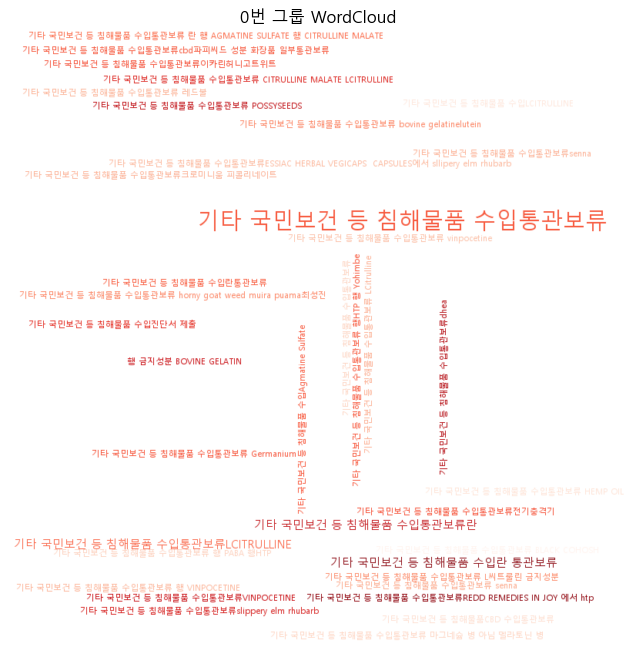

------------------------------------------------------------------------------------------


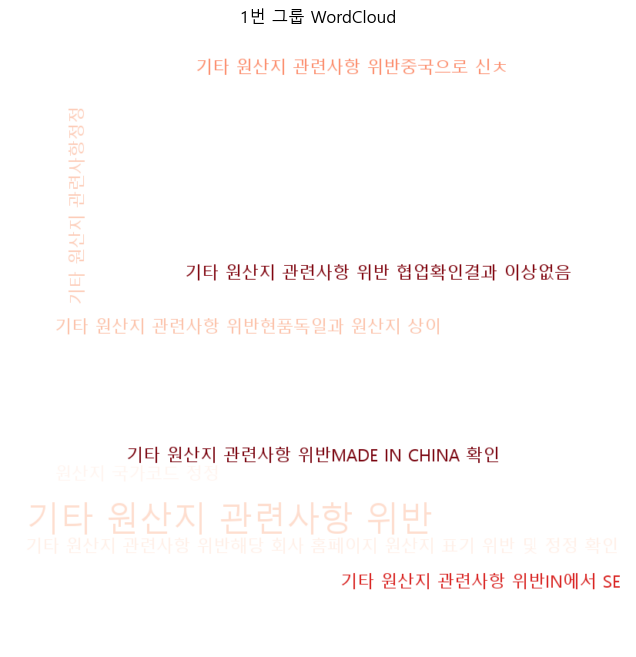

------------------------------------------------------------------------------------------


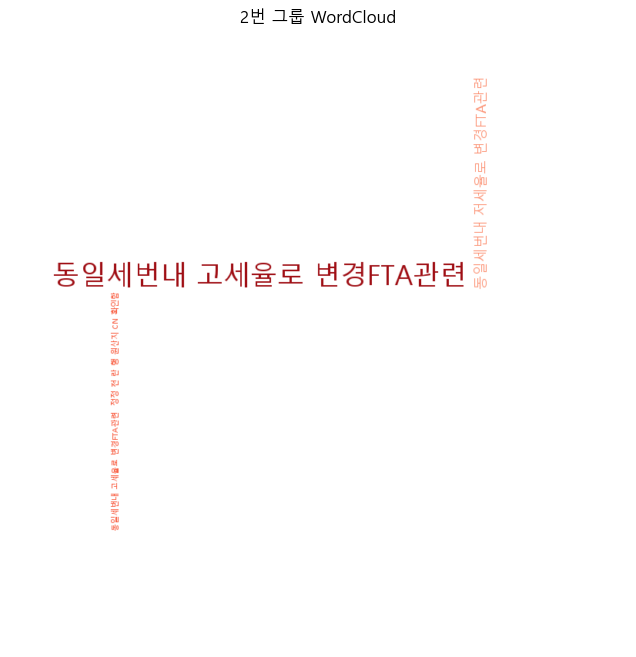

------------------------------------------------------------------------------------------


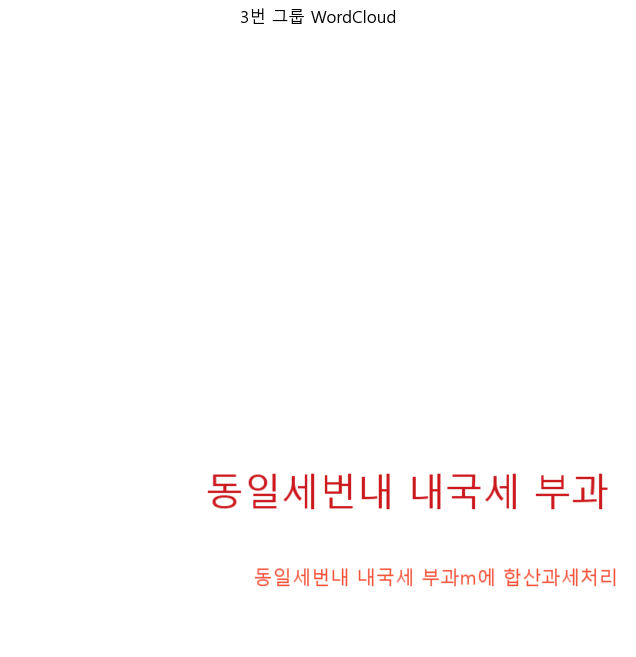

------------------------------------------------------------------------------------------


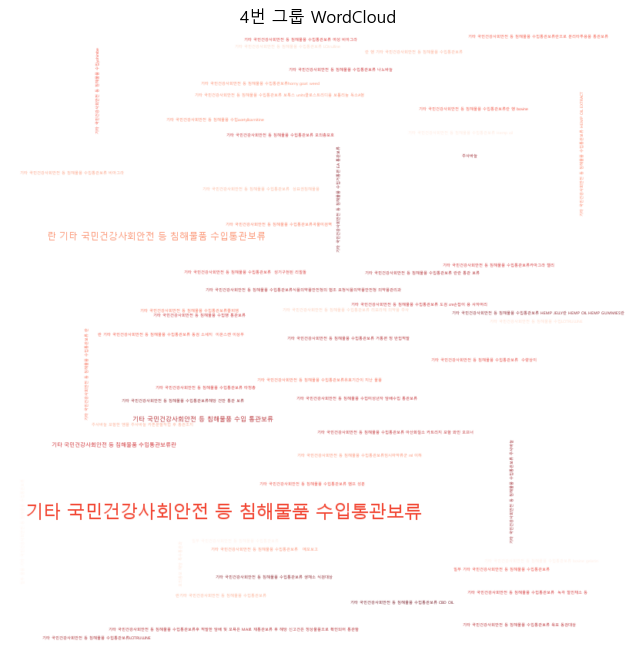

------------------------------------------------------------------------------------------


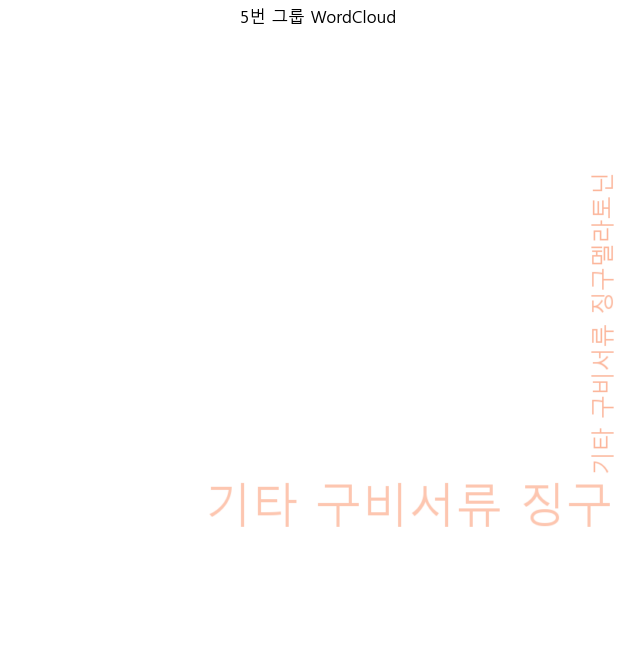

------------------------------------------------------------------------------------------


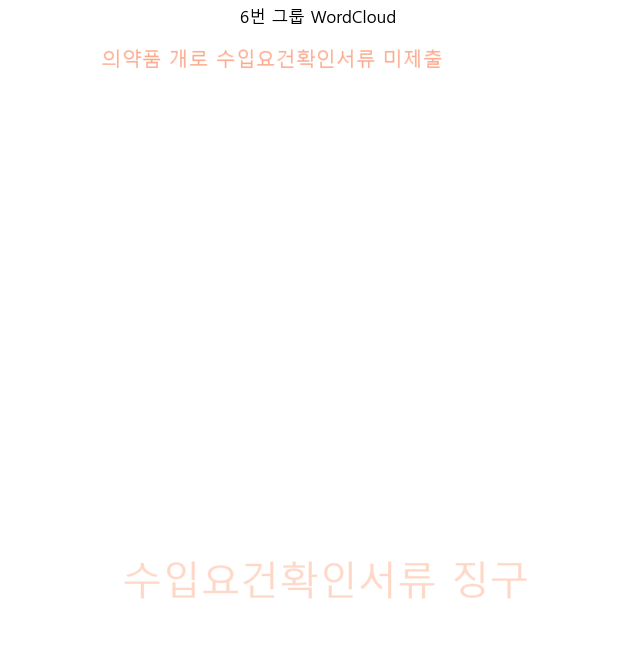

------------------------------------------------------------------------------------------


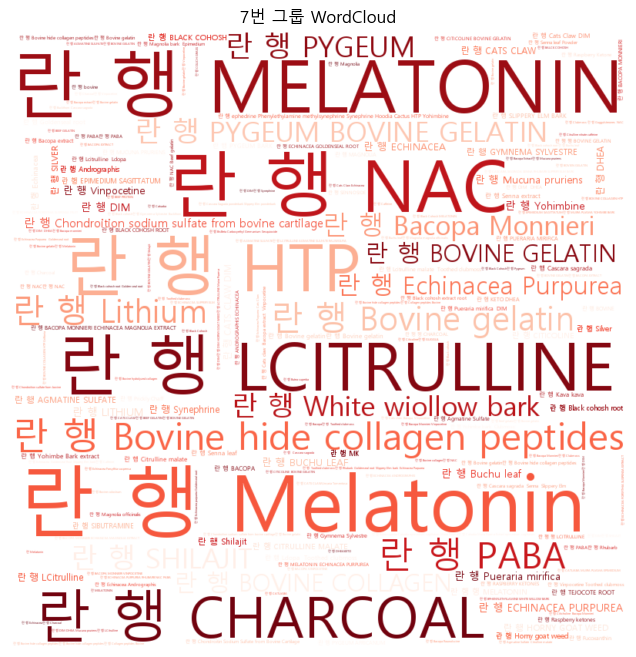

------------------------------------------------------------------------------------------


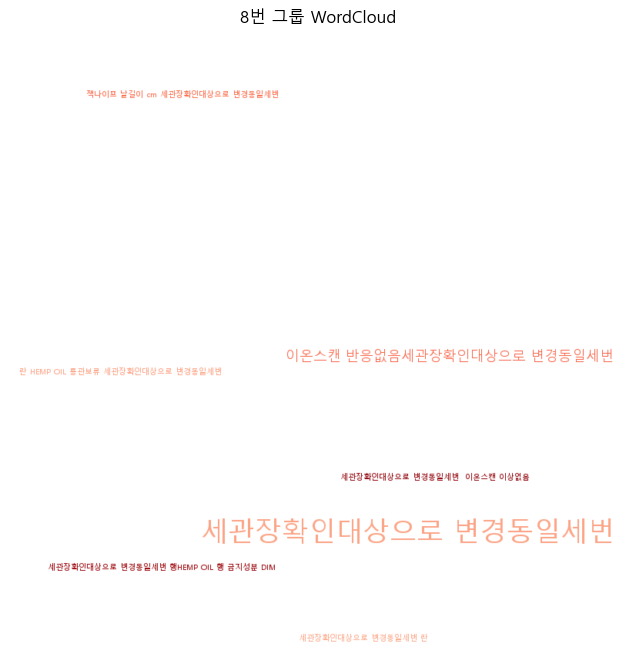

------------------------------------------------------------------------------------------


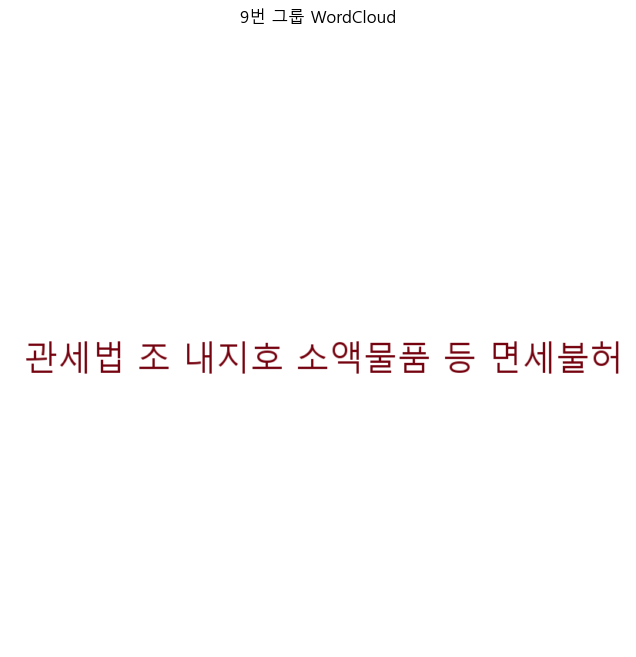

------------------------------------------------------------------------------------------


In [32]:
# 그룹별 워드클라우드 시각화
for i in range(-1, ddf['dbscan'].max()+1):
    wordcloud(i,'dbscan')

In [33]:
# ddf.to_csv('./ttt.csv',index=False,encoding='euc-kr')
ddf.to_excel('./수입검사결과_비지도결과.xlsx',index=False,engine='openpyxl')